In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# Your agent's name here
model_name = "mbappe"

# The epochs you want to sample from
levels = [1, 5, 10, 15, 20]

# The name of the board-variant here
full_name = "5x4silverman"
dims = (5, 4)

# The concepts to make graphs out ofs
concepts = ["material_advantage"]

In [124]:
import tensorflow as tf
from minichess.agents.lite_model import LiteModel
from minichess.agents.predictor_convnet import PredictorConvNet

def load_model(full_name, model_name, epoch):
    keras_model = tf.keras.models.load_model("minichess/agents/checkpoints/{}/{}/{}".format(full_name, model_name, epoch))
    simple_model = PredictorConvNet(LiteModel.from_keras_model(keras_model))
    del keras_model
    return simple_model

agents = [load_model(full_name, model_name, epoch) for epoch in levels]

INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpd36e3rbs\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpd36e3rbs\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmplqbqmtb8\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmplqbqmtb8\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpby2zbrka\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpby2zbrka\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpoc6r0d9u\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpoc6r0d9u\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmp598vc53_\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmp598vc53_\assets


In [125]:
from minichess.chess.move_utils import calculate_all_moves
from game_simulations.tournament import simulate_round_robin_tournament

all_moves, all_moves_inv = calculate_all_moves(dims)
move_cap = all_moves_inv.shape[0]

# Run the round-robin tournament
final_elo = simulate_round_robin_tournament(
    agents, full_name, dims, move_cap, all_moves, all_moves_inv, num_games_per_pair=60, initial_elo=800, max_k=600, min_k=40
)

print("Final ELO Ratings:")
for agent_id, elo in sorted(final_elo.items(), key=lambda x: -x[1]):
    print(f"Agent {agent_id}: {elo:.2f}")

c:\Users\Rares\Desktop\explainable-minichess\minichess\chess\fastchess.py:159: RuntimeWarning: overflow encountered in ulonglong_scalars
  return hash_table[i, j, (occupants * magic) >> np.uint64(64 - shift)]
c:\Users\Rares\Desktop\explainable-minichess\minichess\chess\fastchess_utils.py:421: RuntimeWarning: overflow encountered in ulonglong_scalars
  return board & (board - B_1) != 0


Final ELO Ratings:
Agent 4: 812.72
Agent 2: 809.49
Agent 0: 806.99
Agent 1: 797.17
Agent 3: 773.63


In [126]:
final_elo

{0: 806.9897475919366,
 1: 797.1735447224696,
 2: 809.4892806314588,
 3: 773.6287012260127,
 4: 812.7187258281214}

[0.10250000000000004, 0.10499999999999998]

[0.1825000000000001, 0.15250000000000008]

[0.17999999999999994, 0.2549999999999999]

[0.1775, 0.2649999999999999]

[0.21500000000000008, 0.25249999999999995]



C:\Users\Rares\AppData\Local\Temp\ipykernel_21144\4142503175.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn-muted")


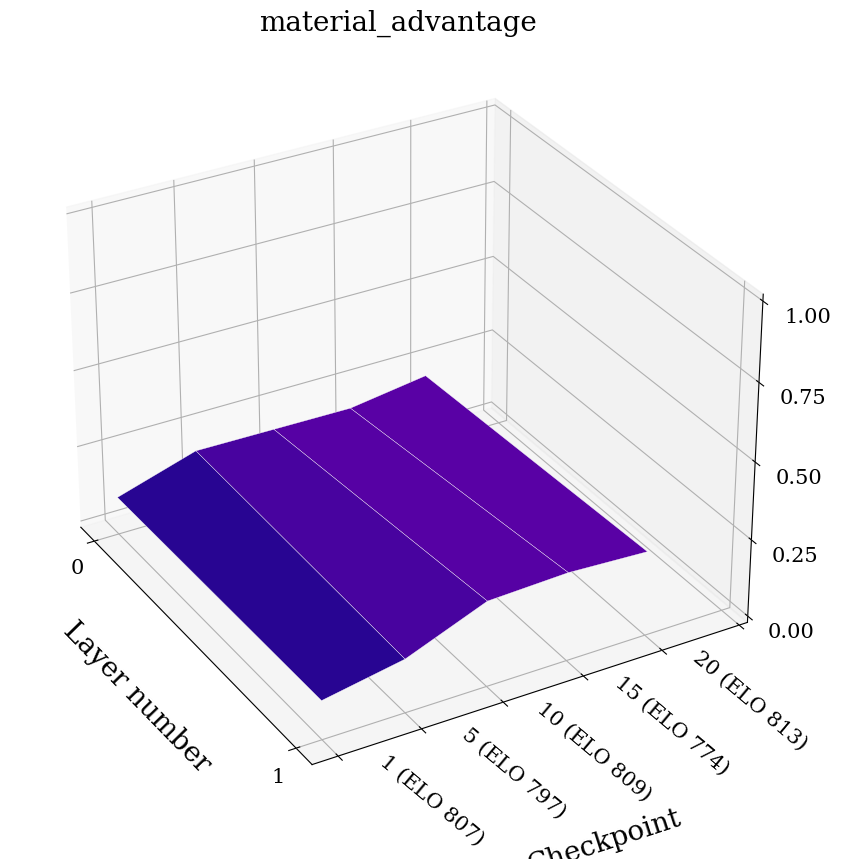

In [127]:
import os
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

for concept in concepts:
    z = []

    for level in levels:
        presences = []
        for file in os.listdir("concept_presences/{}/{}/{}/{}".format(full_name, model_name, concept, level)):
            with open(os.path.join("concept_presences/{}/{}/{}/{}".format(full_name, model_name, concept, level), file)) as f:
                data = json.load(f)
                presences.append(data)

        y = []

        for (i, presence) in enumerate(presences):
            y = []
            for j, ind_presence in enumerate(presence):
                y.append(ind_presence)
            print(y, end="\n\n")
            z.append(y)
    z = np.array(z)

    mpl.style.use("seaborn-muted")
    mpl.rcParams['figure.figsize'] = (10, 11)
    mpl.rcParams['lines.linewidth'] = 20.0

    mpl.rcParams['font.family'] = "serif"
    mpl.rcParams["axes.axisbelow"] = True
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(len(levels))
    Y = np.arange(z.shape[1])
    X, Y = np.meshgrid(Y, X)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, z, cmap=cm.plasma, edgecolor="white", linewidth=0.25, vmin=0.1, vmax=0.9)
    # Customize the z axis.
    ax.set_zlim(0, 1.00)
    ax.set_axisbelow(False)
    ax.set_title(concept, fontsize=20)
    ax.set_xlabel("Layer number", labelpad=15, fontsize=20, zorder=10)
    ax.set_ylabel("Checkpoint", labelpad=55,fontsize=20,zorder=10)
    plt.xticks(fontsize=15, rotation=0)
    plt.xticks(np.arange(z.shape[1]))
    plt.yticks(fontsize=15, rotation=-40)
    ax.tick_params('z', labelsize=15, pad=10, reset=True)
    fig.patch.set_facecolor("white")

    ax.zaxis.set_major_locator(LinearLocator(5))

    labels = [""] + [f"{level} (ELO {int(round(final_elo.get(idx, 0), 0))})" for idx, level in enumerate(levels)]
    plt.yticks(np.arange(len(labels)), labels)
    yticks = ax.yaxis.get_major_ticks()

    yticks[-1].label1.set_visible(True)
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.view_init(30, -30)

    os.makedirs("plots/{}/{}".format(full_name, model_name), exist_ok=True)
    plt.savefig("plots/{}/{}/{}.png".format(full_name, model_name, concept), transparent=False)